# Fire Detection Model Development

This notebook documents the development of an anomaly detection model for fire detection using IoT sensor data. The approach uses an Isolation Forest algorithm trained on synthetic normal sensor readings.

In [46]:
import sys
sys.path.append("c:/Users/sebas/Desktop/Travail/E5/Programming for IoT applications/Project/github/IoT-Fire_Detection_System-PoliTo")

In [47]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from datetime import datetime, timedelta

## Constants

In [48]:
DATASETSIZE = 52560 #update of the sensor every 10 minutes for 1 year

## Synthetic Dataset Generation

The training dataset consists of one year of simulated normal sensor readings sampled every 10 minutes.

### Smoke Sensor Data

In [49]:
# Normal smoke values are near zero with small noise
NOISE_LEVEL = 0.05

smoke_values = np.zeros(DATASETSIZE)
noise = np.random.normal(0.0, NOISE_LEVEL, size=DATASETSIZE)
smoke_values = smoke_values + noise
smoke_values = np.clip(smoke_values, a_min=0.0, a_max=None)

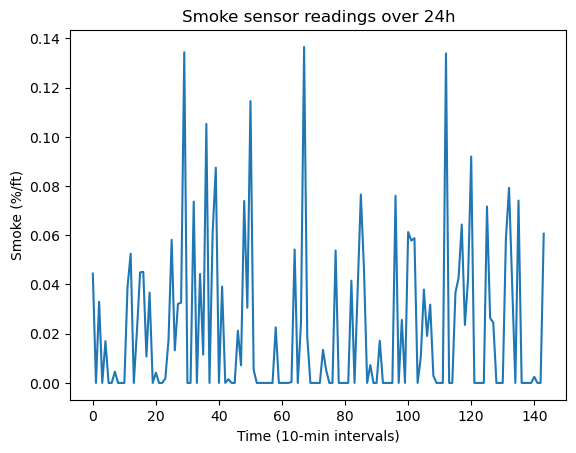

In [50]:
plt.plot(smoke_values[:144])
plt.title("Smoke sensor readings over 24h")
plt.xlabel("Time (10-min intervals)")
plt.ylabel("Smoke (%/ft)")
plt.show()

### CO Sensor Data

CO readings follow a daily pattern extracted from real indoor measurements using spline interpolation.

In [51]:
from src.DevicesConnectors.SensorsSimulation.ModelSensor.ModelSensors.COSensorSimulation import COSensorSimulation

co_sensor = COSensorSimulation("./data_set/indoor_data.csv")
co_sensor.trainModel()
co_model = co_sensor.getModel()


In [52]:
START_DATE = datetime(2025, 1, 1)
co_values = []

for i in range(DATASETSIZE):
    current_time = START_DATE + timedelta(minutes=10 * i)
    seconds_in_day = current_time.hour * 3600 + current_time.minute * 60
    
    co_value = float(co_model(seconds_in_day))
    co_value += np.random.normal(0, 0.5)
    co_values.append(co_value)

co_values = np.array(co_values)
print("Sample values:", co_values[:5])

Sample values: [163.2671834  172.64986352 163.86429642 155.81990246 162.92733555]


### TVOC Sensor Data

TVOC readings also follow a daily pattern from the same indoor dataset.

In [55]:
from src.DevicesConnectors.SensorsSimulation.ModelSensor.ModelSensors.TVOCSensorSimulation import TVOCSensorSimulation

tvoc_sensor = TVOCSensorSimulation("./data_set/indoor_data.csv")
tvoc_sensor.trainModel()
tvoc_model = tvoc_sensor.getModel()

In [56]:
START_DATE = datetime(2025, 1, 1)
tvoc_values = []

for i in range(DATASETSIZE):
    current_time = START_DATE + timedelta(minutes=10 * i)
    seconds_in_day = current_time.hour * 3600 + current_time.minute * 60
    
    tvoc_value = float(tvoc_model(seconds_in_day))
    tvoc_value += np.random.normal(0, 5)
    tvoc_values.append(tvoc_value)

tvoc_values = np.array(tvoc_values)
print("Sample values:", tvoc_values[:5])

Sample values: [13.00541697 39.40971703 24.11158753 47.96328109 69.75106983]


### Temperature Sensor Data

Temperature is modeled using a linear regression with yearly and daily periodic features.

In [76]:
from src.DevicesConnectors.SensorsSimulation.ModelSensor.ModelSensors.TemperatureSensorSimulation import TemperatureSensorSimulation

temperature_sensor = TemperatureSensorSimulation("./data_set/OFFC_EMY.csv")
temperature_sensor.trainModel()
temperature_model = temperature_sensor.getModel()

In [94]:
# Get original data statistics
original_temp = pd.read_csv("./data_set/OFFC_EMY.csv")['Temp'].values
orig_min, orig_max = original_temp.min(), original_temp.max()
orig_mean = original_temp.mean()

# Generate using the trained LinearRegression model
START_DATE = temperature_sensor.dataMinTime
raw_values = []

yearly_period = 365 * 24 * 3600
daily_period = 24 * 3600

for i in range(DATASETSIZE):
    current_time = START_DATE + timedelta(minutes=10 * i)
    elapsed = (current_time - START_DATE).total_seconds()
    
    sin_year = np.sin(2 * np.pi * elapsed / yearly_period)
    cos_year = np.cos(2 * np.pi * elapsed / yearly_period)
    sin_day = np.sin(2 * np.pi * elapsed / daily_period)
    cos_day = np.cos(2 * np.pi * elapsed / daily_period)
    noise = np.random.normal(0, 0.5)
    
    X = np.array([[sin_year, cos_year, sin_day, cos_day, noise]])
    temp_value = temperature_model.predict(X)[0]
    raw_values.append(temp_value)

raw_values = np.array(raw_values)

# Rescale to match original amplitude
gen_min, gen_max = raw_values.min(), raw_values.max()
temperature_values = (raw_values - gen_min) / (gen_max - gen_min) * (orig_max - orig_min) + orig_min

print(f"Model output: min={gen_min:.1f}, max={gen_max:.1f}")
print(f"After rescaling: min={temperature_values.min():.1f}, max={temperature_values.max():.1f}")

Model output: min=0.2, max=28.1
After rescaling: min=-5.0, max=36.0


### Combined Dataset

All sensor readings are combined into a single dataset and saved for training.

In [109]:
dataset = pd.DataFrame({
    'smoke': smoke_values,
    'co': co_values,
    'tvoc': tvoc_values,
    'temperature': temperature_values
})

dataset.to_csv('./data_set/synthetic_sensor_data_1y_10min_update.csv', index=False)
print("Dataset shape:", dataset.shape)

Dataset shape: (52560, 4)


### Dataset Visualization

One day of sensor readings with mean and standard deviation bands.

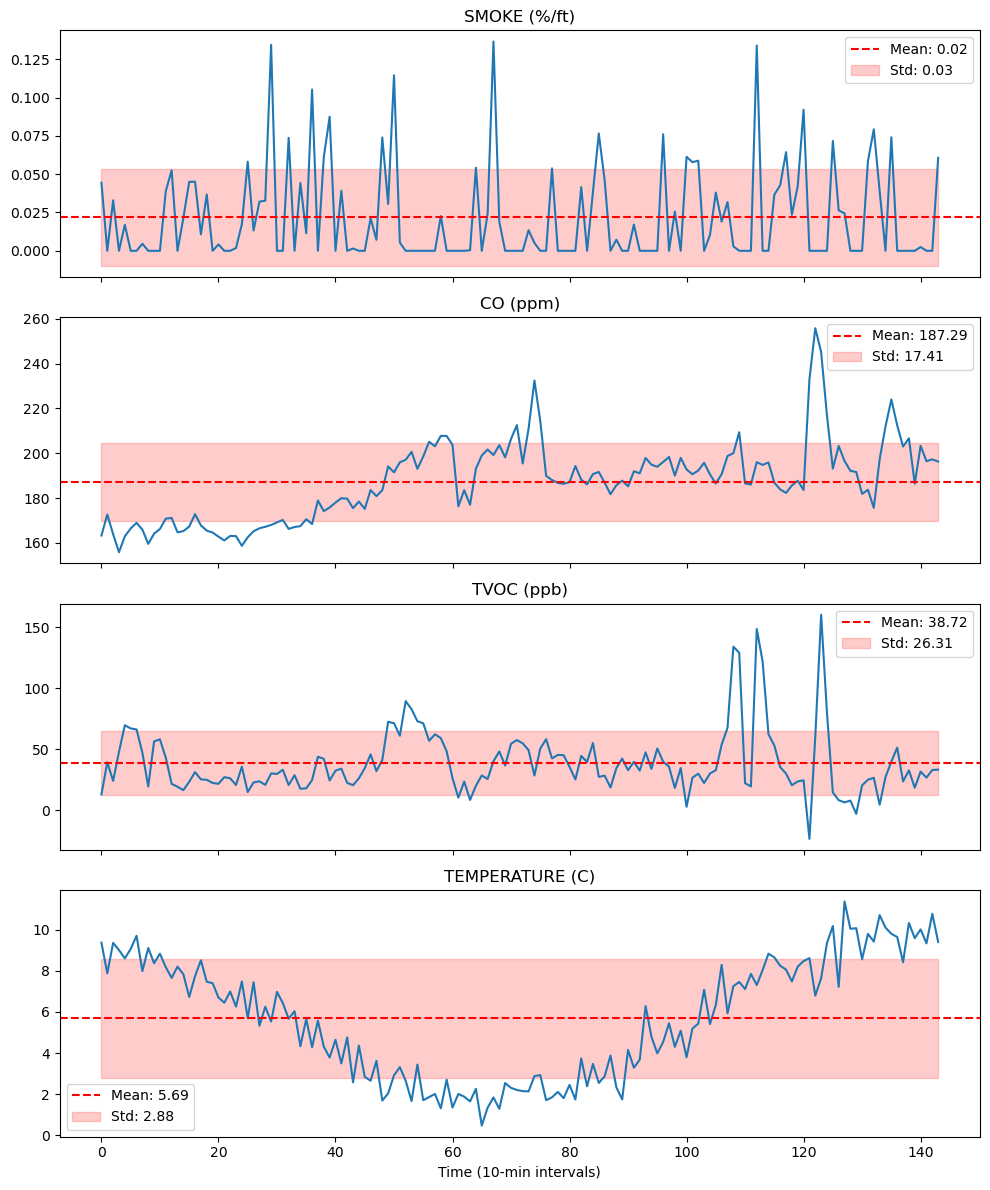

In [110]:
DAY_POINTS = 144
time = np.arange(DAY_POINTS)

fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
sensors = ['smoke', 'co', 'tvoc', 'temperature']
units = ['%/ft', 'ppm', 'ppb', 'C']
data_arrays = [smoke_values, co_values, tvoc_values, temperature_values]

for idx, (sensor, unit, values) in enumerate(zip(sensors, units, data_arrays)):
    day_data = values[:DAY_POINTS]
    mean_val = np.mean(day_data)
    std_val = np.std(day_data)
    
    axs[idx].plot(time, day_data)
    axs[idx].axhline(mean_val, color='r', linestyle='--', label=f"Mean: {mean_val:.2f}")
    axs[idx].fill_between(time, mean_val - std_val, mean_val + std_val, 
                          color='r', alpha=0.2, label=f"Std: {std_val:.2f}")
    axs[idx].set_title(f"{sensor.upper()} ({unit})")
    axs[idx].legend()

plt.xlabel("Time (10-min intervals)")
plt.tight_layout()
plt.show()

## Anomaly Detection Model

We use an Isolation Forest trained on normal sensor data. The model learns the distribution of typical readings and flags outliers as potential fire events.

In [111]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

np.random.seed(42)

# Load dataset
dataset = pd.read_csv('./data_set/synthetic_sensor_data_1y_10min_update.csv')
print("Dataset loaded:", dataset.shape)

# Compute baseline statistics
BASELINE_STATS = {}
for col in ['smoke', 'co', 'tvoc', 'temperature']:
    BASELINE_STATS[col] = {
        'mean': dataset[col].mean(),
        'std': dataset[col].std()
    }

# Sensor importance weights
WEIGHTS = {
    'smoke': 5.0,
    'co': 4.0,
    'temperature': 3.0,
    'tvoc': 2.0
}

# Apply weights
dataset_weighted = dataset.copy()
for col, w in WEIGHTS.items():
    dataset_weighted[col] = dataset[col] * w

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(dataset_weighted)

# Train Isolation Forest
model = IsolationForest(
    n_estimators=500,
    contamination=0.01,
    max_samples=256,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train)
print("Model trained")

# Calibrate on training data
train_scores = model.decision_function(X_train)
score_threshold = np.percentile(train_scores, 5)
score_mean = train_scores.mean()
score_std = train_scores.std()
print(f"Score stats: mean={score_mean:.4f}, std={score_std:.4f}")

# Save model
joblib.dump(model, 'model/modele_incendie.pkl')
joblib.dump(scaler, 'model/scaler_incendie.pkl')
joblib.dump(WEIGHTS, 'model/weights.pkl')
joblib.dump(BASELINE_STATS, 'model/baseline_stats.pkl')
joblib.dump({'mean': score_mean, 'std': score_std, 'threshold': score_threshold}, 
            'model/score_calibration.pkl')
print("Model saved")

Dataset loaded: (52560, 4)
Model trained
Score stats: mean=0.1895, std=0.0565
Model saved


### Prediction Function

Function to predict fire probability from sensor readings using the trained model.

In [112]:
from collections import deque

# Historical buffer for temporal smoothing
HISTORY_SIZE = 100
sensor_history = {
    'smoke': deque(maxlen=HISTORY_SIZE),
    'co': deque(maxlen=HISTORY_SIZE),
    'tvoc': deque(maxlen=HISTORY_SIZE),
    'temperature': deque(maxlen=HISTORY_SIZE)
}

def get_smoothed_values(smoke, co, tvoc, temp):
    """
    Add current readings to history and return smoothed values.
    Uses rolling mean to filter transient noise.
    """
    sensor_history['smoke'].append(smoke)
    sensor_history['co'].append(co)
    sensor_history['tvoc'].append(tvoc)
    sensor_history['temperature'].append(temp)
    
    # Compute rolling statistics
    smoothed = {}
    for sensor, history in sensor_history.items():
        if len(history) < 10:
            # Not enough history, use raw value
            smoothed[sensor] = history[-1]
        else:
            # Use rolling mean for smoothing
            smoothed[sensor] = np.mean(list(history))
    
    return smoothed['smoke'], smoothed['co'], smoothed['tvoc'], smoothed['temperature']

def reset_history():
    """Clear sensor history buffer."""
    for history in sensor_history.values():
        history.clear()

def predict_fire_proba(smoke, co, tvoc, temp, use_smoothing=True, verbose=True):
    """
    Predict fire probability using Isolation Forest.
    
    Args:
        smoke, co, tvoc, temp: Raw sensor readings
        use_smoothing: If True, apply temporal smoothing using historical values
        verbose: If True, print prediction details
    
    Returns:
        Dictionary with prediction, probability, confidence, and alert level.
    """
    # Apply temporal smoothing if enabled
    if use_smoothing:
        smoke_s, co_s, tvoc_s, temp_s = get_smoothed_values(smoke, co, tvoc, temp)
    else:
        smoke_s, co_s, tvoc_s, temp_s = smoke, co, tvoc, temp
    
    # Compute deviations from baseline
    deviations = {}
    deviations['smoke'] = (smoke_s - BASELINE_STATS['smoke']['mean']) / BASELINE_STATS['smoke']['std']
    deviations['co'] = (co_s - BASELINE_STATS['co']['mean']) / BASELINE_STATS['co']['std']
    deviations['tvoc'] = (tvoc_s - BASELINE_STATS['tvoc']['mean']) / BASELINE_STATS['tvoc']['std']
    deviations['temperature'] = (temp_s - BASELINE_STATS['temperature']['mean']) / BASELINE_STATS['temperature']['std']
    
    # Prepare weighted input
    weighted_input = np.array([[
        smoke_s * WEIGHTS['smoke'],
        co_s * WEIGHTS['co'],
        tvoc_s * WEIGHTS['tvoc'],
        temp_s * WEIGHTS['temperature']
    ]])
    input_df = pd.DataFrame(weighted_input, columns=['smoke', 'co', 'tvoc', 'temperature'])
    input_scaled = scaler.transform(input_df)
    
    # Get anomaly score
    anomaly_score = model.decision_function(input_scaled)[0]
    
    # Convert to probability using sigmoid
    relative_score = (anomaly_score - score_threshold) / score_std
    fire_prob = 1 / (1 + np.exp(relative_score * 1.5))
    
    # Boost for high deviations
    high_dev_count = sum(1 for d in deviations.values() if d > 3)
    if high_dev_count >= 1:
        fire_prob = min(0.99, fire_prob + 0.2 * high_dev_count)
    
    weighted_dev = sum(max(0, d) * WEIGHTS[s] for s, d in deviations.items())
    if weighted_dev > 10:
        fire_prob = min(0.99, fire_prob + weighted_dev / 100)
    
    fire_prob = np.clip(fire_prob, 0.01, 0.99)
    confidence = min(0.99, abs(fire_prob - 0.5) * 2)
    
    # Alert level
    if fire_prob < 0.20:
        alert = 'NORMAL'
    elif fire_prob < 0.40:
        alert = 'WARNING'
    elif fire_prob < 0.70:
        alert = 'DANGER'
    else:
        alert = 'CRITICAL'
    
    prediction = -1 if fire_prob > 0.5 else 1
    
    if verbose:
        status = "FIRE" if prediction == -1 else "OK"
        print(f"{status:6} | prob={fire_prob:.1%} | conf={confidence:.1%} | alert={alert}")
    
    return {
        'prediction': prediction,
        'fire_probability': fire_prob,
        'confidence': confidence,
        'alert_level': alert,
        'anomaly_score': anomaly_score,
        'details': deviations,
        'smoothed_values': {'smoke': smoke_s, 'co': co_s, 'tvoc': tvoc_s, 'temperature': temp_s}
    }

## Model Evaluation

Testing on a balanced dataset of normal readings and synthetic anomalies with varying severity levels.

In [114]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load baseline stats
dataset_stats = pd.read_csv('./data_set/synthetic_sensor_data_1y_10min_update.csv')
stats = {col: {'mean': dataset_stats[col].mean(), 'std': dataset_stats[col].std()} 
         for col in ['smoke', 'co', 'tvoc', 'temperature']}

print("Baseline statistics:")
for sensor, s in stats.items():
    print(f"  {sensor}: {s['mean']:.3f} +/- {s['std']:.3f}")

# Generate test data
np.random.seed(42)
N_NORMAL = 150
N_ANOMALY = 150

# Normal samples
normal_data = []
for _ in range(N_NORMAL):
    row = [max(0, np.random.normal(stats[s]['mean'], stats[s]['std'])) 
           for s in ['smoke', 'co', 'tvoc', 'temperature']]
    normal_data.append(row)

# Anomalous samples with varying severity
anomalous_data = []
severity_levels = []

for i in range(N_ANOMALY):
    row = {s: np.random.normal(stats[s]['mean'], stats[s]['std']) 
           for s in ['smoke', 'co', 'tvoc', 'temperature']}
    row['smoke'] = max(0, row['smoke'])
    
    # Severity based on standard deviation multiplier
    if i < 30:
        severity, k = "light", np.random.uniform(2.5, 3.5)
    elif i < 70:
        severity, k = "moderate", np.random.uniform(3.5, 4.5)
    elif i < 110:
        severity, k = "strong", np.random.uniform(4.5, 6)
    else:
        severity, k = "critical", np.random.uniform(6, 10)
    
    severity_levels.append(severity)
    
    # Perturb 1-3 sensors
    weights = [0.35, 0.30, 0.20, 0.15]
    n_sensors = np.random.choice([1, 2, 3], p=[0.3, 0.5, 0.2])
    sensors = np.random.choice(['smoke', 'co', 'temperature', 'tvoc'], 
                               size=n_sensors, replace=False, p=weights)
    
    for sensor in sensors:
        row[sensor] = stats[sensor]['mean'] + k * stats[sensor]['std']
    
    anomalous_data.append([row['smoke'], row['co'], row['tvoc'], row['temperature']])

# Combine datasets
data = np.vstack([normal_data, anomalous_data])
labels = np.array([1] * N_NORMAL + [0] * N_ANOMALY)

test_df = pd.DataFrame(data, columns=['smoke', 'co', 'tvoc', 'temperature'])
test_df['label'] = labels
test_df.loc[N_NORMAL:, 'severity'] = severity_levels

print(f"\nTest set: {N_NORMAL} normal + {N_ANOMALY} anomalies")

# Run predictions (smoothing disabled for independent sample evaluation)
results = []
for _, row in test_df.iterrows():
    r = predict_fire_proba(row['smoke'], row['co'], row['tvoc'], row['temperature'], 
                          use_smoothing=False, verbose=False)
    results.append(r)

test_df['prediction'] = [r['prediction'] for r in results]
test_df['fire_probability'] = [r['fire_probability'] for r in results]
test_df['anomaly_score'] = [r['anomaly_score'] for r in results]

pred_labels = (test_df['prediction'] == 1).astype(int)

# Metrics
accuracy = accuracy_score(test_df['label'], pred_labels)
cm = confusion_matrix(test_df['label'], pred_labels)

print("\n" + "="*50)
print("RESULTS")
print("="*50)
print(f"\nAccuracy: {accuracy:.1%}")
print("\nClassification Report:")
print(classification_report(test_df['label'], pred_labels, 
                           target_names=['Fire', 'Normal'], digits=3))

print("Confusion Matrix:")
print(f"               Pred Normal   Pred Fire")
print(f"True Normal    {cm[1,1]:^11}   {cm[1,0]:^9}")
print(f"True Fire      {cm[0,1]:^11}   {cm[0,0]:^9}")

# Detection by severity
print("\n" + "="*50)
print("Detection Rate by Severity")
print("="*50)

anomalies_df = test_df[test_df['label'] == 0]
for severity in ['light', 'moderate', 'strong', 'critical']:
    subset = anomalies_df[anomalies_df['severity'] == severity]
    if len(subset) == 0:
        continue
    detected = (subset['prediction'] == -1).sum()
    total = len(subset)
    rate = detected / total * 100
    print(f"{severity:10}: {rate:5.1f}% ({detected}/{total})")

# Probability distributions
normal_probs = test_df[test_df['label'] == 1]['fire_probability']
anomaly_probs = test_df[test_df['label'] == 0]['fire_probability']

print("\nProbability Distribution:")
print(f"  Normal:  {normal_probs.mean():.1%} +/- {normal_probs.std():.1%}")
print(f"  Anomaly: {anomaly_probs.mean():.1%} +/- {anomaly_probs.std():.1%}")

# Final summary
tp, fn = cm[0, 0], cm[0, 1]
fp, tn = cm[1, 0], cm[1, 1]
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print(f"""
Model: Isolation Forest
  - Trees: 500
  - Contamination: 1%
  - Weights: smoke x5, co x4, temp x3, tvoc x2
  - Temporal smoothing: 100 samples rolling mean

Performance:
  - Accuracy:  {accuracy:.1%}
  - Precision: {precision:.1%}
  - Recall:    {recall:.1%}
  - F1 Score:  {f1:.1%}

Errors:
  - False positives: {fp}
  - False negatives: {fn}
""")

Baseline statistics:
  smoke: 0.020 +/- 0.029
  co: 187.271 +/- 17.503
  tvoc: 38.040 +/- 25.958
  temperature: 15.078 +/- 10.454

Test set: 150 normal + 150 anomalies

RESULTS

Accuracy: 95.3%

Classification Report:
              precision    recall  f1-score   support

        Fire      0.959     0.947     0.953       150
      Normal      0.947     0.960     0.954       150

    accuracy                          0.953       300
   macro avg      0.953     0.953     0.953       300
weighted avg      0.953     0.953     0.953       300

Confusion Matrix:
               Pred Normal   Pred Fire
True Normal        144           6    
True Fire           8           142   

Detection Rate by Severity
light     :  83.3% (25/30)
moderate  :  95.0% (38/40)
strong    :  97.5% (39/40)
critical  : 100.0% (40/40)

Probability Distribution:
  Normal:  12.0% +/- 16.6%
  Anomaly: 94.1% +/- 15.4%

MODEL SUMMARY

Model: Isolation Forest
  - Trees: 500
  - Contamination: 1%
  - Weights: smoke x5, co 